#### Welcome to the Cassandra project

The goal of the project is to transform a number of .csv files to 3 optimized Cassandra tables, ready to execute 3 specific queries. 

To reach this goal we need to do the following:
- transform the .csv files to a ready for insertion list of tuples
- inspect the distribution of the potential partition keys 
- create the Cassandra tables
- insert the data
- validate the queries

In [1]:
from pathlib import Path
from src.create_event_data import CreateEventData
from src.data_utils import create_csv_path_list

#### Step 1: transform the .csv files to a ready for insertion list of tuples

In [2]:
event_data_path = Path('..') / 'event_data'
csv_list = create_csv_path_list(event_data_path)

..\event_data contains 30 .csv files.


In [3]:
create_event_instance = CreateEventData(csv_path_list=csv_list)

In [4]:
return_df, event_data = create_event_instance.data_pipeline()

INFO 2020-12-30 08:22:12,782 [create_event_data.py:data_pipeline:36] Data pipeline started...


Processed 1 / 30 .csv files
Processed 2 / 30 .csv files
Processed 3 / 30 .csv files
Processed 4 / 30 .csv files
Processed 5 / 30 .csv files
Processed 6 / 30 .csv files
Processed 7 / 30 .csv files
Processed 8 / 30 .csv files
Processed 9 / 30 .csv files
Processed 10 / 30 .csv files
Processed 11 / 30 .csv files
Processed 12 / 30 .csv files
Processed 13 / 30 .csv files
Processed 14 / 30 .csv files
Processed 15 / 30 .csv files
Processed 16 / 30 .csv files
Processed 17 / 30 .csv files
Processed 18 / 30 .csv files
Processed 19 / 30 .csv files
Processed 20 / 30 .csv files
Processed 21 / 30 .csv files
Processed 22 / 30 .csv files
Processed 23 / 30 .csv files
Processed 24 / 30 .csv files
Processed 25 / 30 .csv files
Processed 26 / 30 .csv files
Processed 27 / 30 .csv files
Processed 28 / 30 .csv files
Processed 29 / 30 .csv files
Processed 30 / 30 .csv files


#### Step 2: inspect the distribution of the potential partition keys

####  Create queries to ask the following three questions of the data

##### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


##### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

##### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'


In [5]:
return_df.head(n=3)

,artist,firstName,gender,itemInSession,lastName,length,level,location,sessionId,song,userId
0,Des'ree,Kaylee,F,1,Summers,246.30812,free,"Phoenix-Mesa-Scottsdale, AZ",139,You Gotta Be,8
1,Mr Oizo,Kaylee,F,3,Summers,144.03873,free,"Phoenix-Mesa-Scottsdale, AZ",139,Flat 55,8
2,Tamba Trio,Kaylee,F,4,Summers,177.18812,free,"Phoenix-Mesa-Scottsdale, AZ",139,Quem Quiser Encontrar O Amor,8


In [12]:
return_df.shape

(6820, 11)

In [20]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
session_id_values = Counter(return_df['sessionId']).values()

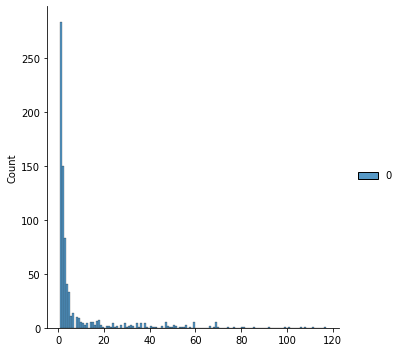

In [21]:
sns.displot(session_id_values)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.kdeplot(data=camp_1_A, fill=True, ax=ax)
plt.setp(ax.get_legend().get_texts(), fontsize='14')

ax.set_xlabel('underlying probability of success', fontsize=12)    
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xticklabels([f"{round(x*100, 2)}%" for x in np.arange(0, 1.1, 0.1)])

fig.suptitle('What underlying probabilities could have caused the found result?', fontsize=18)
# fig.savefig('session_id_distribution.jpg')
;